
# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Análisis y visualización de datos

### Trabajo práctico entregable - Grupo 22 - Parte 1

**Integrantes:**
- Chevallier-Boutell, Ignacio José
- Ribetto, Federico Daniel
- Rosa, Santiago

**Seguimiento:** Meinardi, Vanesa


**Observación:** como los datasets son muy pequeños, nuestro flujo de trabajo se basó en hacer copias *ad hoc*. Somos concientes que esto es un gasto innecesario de memoria pero que no tiene un impacto en la performance en este caso. no nos bajen puntos porfis.

---

## Librerías

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

pd.set_option('display.max_rows', 1000) # cambiar el número de filas que se mostrarán usando display.max_rows.
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.options.mode.chained_assignment = None  # default='warn'

sns.set_context('talk')
sns.set_theme(style='white')

## Lectura del dataset

El dataset a utilizar es la encuesta Sysarmy del año 2022 versión 2, en formato csv, la cual es una una encuesta personal y voluntaria que busca relevar información sobre salarios y condiciones de trabajo de programadores, que se realiza anualmente. Se analizarán sólo los datos provenientes de Argentina. 

Se utilizará un dataset que ya ha tenido un pretratamiento: 
* Se eliminó el encabezado de la encuesta original.
* Se renombraron las columnas.

Este dataset está disponible en internet, desde donde lo usaremos.

In [2]:
url = 'https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2022_processed.csv'
df = pd.read_csv(url)
total_ans = len(df) # cantidad de respuestas en el dataset

---
# Ejercicio 1 - Análisis descriptivo

## Selección de columnas

En este primer ejercicio, debemos dar respuesta a **¿Cuáles son los lenguajes de programación asociados a los mejores salarios?** Para ello, creemos que las columnas que contienen la información relevante son salary_monthly_BRUTO, salary_monthly_NETO y tools_programming_languages. Crearemos un nuevo DataFrame que contenga entonces sólo esta información. Luego, eliminamos las filas que están vacías.

**Observación:** tomaremos también las variables categóricas work_province, profile_gender y profile_studies_level junto a las variables numéricas profile_years_experience y profile_age ya que el proceso de filtrado que haremos nos sirve como puntapié para responder el ejercicio 2.

In [21]:
relevant_columns = ["salary_monthly_BRUTO",
                    "salary_monthly_NETO",
                    "tools_programming_languages", 
                    "profile_years_experience", 
                    "profile_age", 
                    "work_province", 
                    "profile_gender", 
                    "profile_studies_level"]

df1 = df[relevant_columns] # Nuevo DataFrame

print(f'Cantidad inicial de filas: {total_ans}.')
df1 = df1.dropna(subset=relevant_columns[0:3])
print(f'Quedan {len(df1)} filas.')

Cantidad inicial de filas: 5358.
Quedan 5356 filas.


## Análisis preliminar

La estadística descriptiva del sueldo bruto muestra que hay una gran dispersión de datos: el sueldo bruto promedio es de $363.445, pero hay gente que llega a cobrar hasta 28 millones de pesos (más de 77 veces la media). Esto se ve reflejado también en su gran desviación estándar. Vemos también que hay gente que supuestamente tiene un sueldo nulo. Algo similar se observa con el sueldo neto.

In [4]:
print('Resultados del describe:')
print(df1[["salary_monthly_BRUTO","salary_monthly_NETO"]].describe().round(0))

Resultados del describe:
       salary_monthly_BRUTO  salary_monthly_NETO
count                5356.0               5356.0
mean               363445.0             276969.0
std                544015.0             402009.0
min                     0.0                  0.0
25%                150000.0             118565.0
50%                256000.0             201000.0
75%                411948.0             294000.0
max              28000000.0           15000000.0


Esto mismo lo apreciamos gráficamente: vemos que la distribución es extremadamente asimétrica, teniendo una cola ampliamente extendida hacia la derecha. Además, considerando que el Salario Mínimo Vital y Móvil (SMVM) en Abril de 2022 es de $38.940, hay varias respuestas que caen por debajo de este valor.

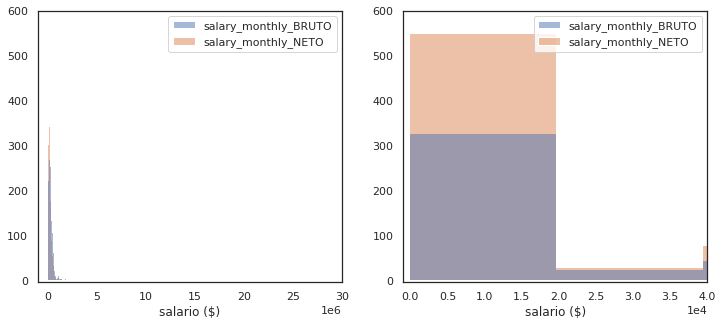

In [5]:
fig, axs = plt.subplots(1,2, figsize=(12,5))

sns.histplot(df1[["salary_monthly_BRUTO","salary_monthly_NETO"]], ax=axs[0], color='steelblue', label=["bruto","neto"])
#corregir labels de los histogramas

axs[0].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs[0].set_ylim((-5,600))
axs[0].set_xlim((-1*10**6,30*10**6))
axs[0].set_ylabel("")
axs[0].set_xlabel("salario ($)")

sns.histplot(df1[["salary_monthly_BRUTO","salary_monthly_NETO"]], ax=axs[1], color='steelblue', label=["bruto","neto"])
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(4,4))
axs[1].set_ylim((-5,600))
axs[1].set_xlim((-1000,4*10**4))
axs[1].set_ylabel("")
axs[1].set_xlabel("salario ($)")

plt.show()

Analicemos ahora la relación entre el sueldo bruto y el neto. Sabemos que el sueldo bruto tiene que ser estrictamente mayor que el sueldo neto. Esto implica que, gráficamente, todos los puntos deberían caer por encima de la diagonal principal (marcada en rojo). Limpiamos entonces los datos, considerando esta condición. Notamos también que hay una serie de datos encolumnados en torno a un sueldo neto nulo.

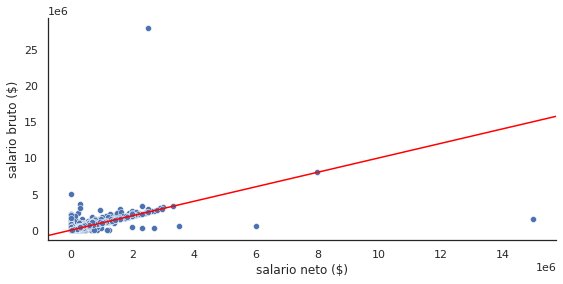

In [6]:
sns.pairplot(data=df1, y_vars=['salary_monthly_BRUTO'], x_vars=['salary_monthly_NETO'], aspect=2, height=4)
plt.ticklabel_format(style='sci', axis='both', scilimits=(6,6))
plt.axline(xy1=(10000, 10000), xy2=(2000000, 2000000), color="red")
plt.xlabel("salario neto ($)")
plt.ylabel("salario bruto ($)")
plt.show()

## Filtrado/limpieza

Primero vamos a eliminar aquellos datos que no cumplan con la condición de que el sueldo bruto sea estrictamente mayor que el neto. Además, dada la pregunta que queremos responder, vamos a quedarnos con aquellas personas que cobran desde un SMVM hasta hasta 2 millones de pesos, inclusive, imponiendo estas condiciones sobre el sueldo neto.

In [7]:
print(f'Con todos los datos, teníamos {len(df1)} filas.')

df_acot = df1
df_acot = df_acot[df_acot["salary_monthly_BRUTO"]>df_acot["salary_monthly_NETO"]] # Filtramos bruto > neto

SMVM = 38940
df_acot = df_acot[df_acot["salary_monthly_NETO"]>=SMVM] # Filtramos desde el SMVM.
df_acot = df_acot[df_acot["salary_monthly_NETO"]<=2*1e6] # Filtramoshasta 2 millones.

print(f'Luego de filtrar, nos quedan {len(df_acot)} filas.')



Con todos los datos, teníamos 5356 filas.
Luego de filtrar, nos quedan 4121 filas.


Luego de filtrar, repetimos el pairplot y vemos que ahora tiene más sentido.

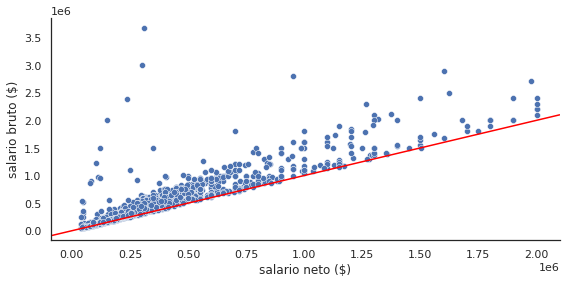

In [8]:
sns.pairplot(data=df_acot, y_vars=['salary_monthly_BRUTO'], x_vars=['salary_monthly_NETO'], aspect=2, height=4)
plt.ticklabel_format(style='sci', axis='both', scilimits=(6,6))
plt.axline(xy1=(10000, 10000), xy2=(2000000, 2000000), color="red")
plt.xlabel("salario neto ($)")
plt.ylabel("salario bruto ($)")
plt.show()

Al repetir los histogramas, vemos que aún tenemos una distribución bastante asimetríca con muchos puntos a derecha, tanto en bruto como en neto.

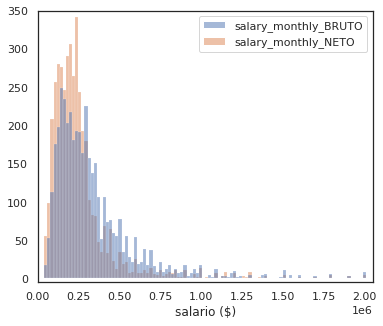

In [9]:
fig, axs = plt.subplots(figsize=(6,5))

# corregir labels

sns.histplot(df_acot[["salary_monthly_BRUTO","salary_monthly_NETO"]], ax=axs, color='steelblue')
axs.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs.set_ylim((-5,350))
axs.set_xlim((0,2.05*10**6))
axs.set_xlabel("salario ($)")
axs.set_ylabel("")
plt.show()

## Selección de la porción central de la distribución

Consideramos que sería apropiado tomar el 85 % central de nuestra muestra para llevar a cabo el análisis. Como suele de ser de interés el sueldo "de bolsillo" (el neto), seguiremos en adelante considerando sólo el sueldo neto y dejando de lado el bruto.

In [10]:
print(f'Teníamos {len(df_acot)} filas.')

df85 = df_acot[["salary_monthly_NETO","tools_programming_languages", "profile_years_experience", "profile_age", "work_province", "profile_gender"]] # Nuevo DataFrame

k = 15
percentile_inf = df85["salary_monthly_NETO"].quantile(k * 0.5 / 100)
percentile_sup = df85["salary_monthly_NETO"].quantile((100 - k * 0.5) / 100)

df85 = df85[df85["salary_monthly_NETO"] > percentile_inf]
df85 = df85[df85["salary_monthly_NETO"] < percentile_sup]

print(f'Tomando el 85% central ahora tenemos {len(df85)} filas.')


Teníamos 4121 filas.
Tomando el 85% central ahora tenemos 3479 filas.


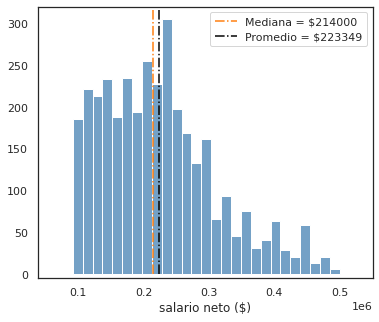

In [11]:
fig, axs = plt.subplots(figsize=(6,5))

sns.histplot(df85["salary_monthly_NETO"], ax=axs, color='steelblue', legend=False)
axs.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axs.set_ylim((-5,320))
axs.set_xlim((38000, 0.55*10**6))
axs.set_xlabel("salario neto ($)")
axs.set_ylabel("")
axs.vlines(df85["salary_monthly_NETO"].median(), 0, np.amax(df85["salary_monthly_NETO"]), color="tab:orange", label = f'Mediana = ${df85["salary_monthly_NETO"].median():.0f}', ls='-.')
axs.vlines(df85["salary_monthly_NETO"].mean(), 0, np.amax(df85["salary_monthly_NETO"]), color="black", label = f'Promedio = ${df85["salary_monthly_NETO"].mean():.0f}', ls='-.')
axs.legend()

plt.show()

## Selección de lenguajes de programación a analizar



La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`, la cual no hemos considerado hasta ahora. Lo primero que hay que hacer es eliminar aquellas entradas cuya respuesta sea "Ninguna de las anteriores". Luego  separar las listas de lenguajes, para que queden cada uno por su cuenta, asociado al respectivo sueldo neto. En la columna `programming_language` se encuentra cada lenguaje por separado (las filas con igual índice hacen referencia a la misma persona).

In [12]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
    if not isinstance(languages_str, str):
    
        return []
  
    # Remove 'other' option
    languages_str = languages_str.lower().replace('ninguno de los anteriores', '')
    # Split string into list of items
    # Remove spaces and commas for each item
    return [lang.strip().replace(',', '') for lang in languages_str.split()]

# Create a new column with the list of languages
df85.loc[:, 'cured_programming_languages'] = df85.tools_programming_languages\
    .apply(split_languages)

new_relevant_columns = ["salary_monthly_NETO","tools_programming_languages", "cured_programming_languages"]

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.

# Uso la columna que me interesa
# Transformo a series. No entiendo por que hay 19 columnas.
# Desdoblado línea por línea para que se entienda.
df_lang = df85["cured_programming_languages"].apply(pd.Series)
df_lang = df_lang.stack()
df_lang = df_lang.reset_index(level=-1, drop=True)
df_lang = df_lang.to_frame()
df_lang = df_lang.join(df85[new_relevant_columns])
df_lang = df_lang.rename(columns={0: 'programming_language'})

print(df_lang[:5])
print(len(df_lang))

/tmp/ipykernel_10113/2304986239.py:28: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_lang = df85["cured_programming_languages"].apply(pd.Series)


  programming_language  salary_monthly_NETO tools_programming_languages cured_programming_languages
0               python             245000.0                      Python                    [python]
2           javascript             115000.0     Javascript, PHP, Python   [javascript, php, python]
2                  php             115000.0     Javascript, PHP, Python   [javascript, php, python]
2               python             115000.0     Javascript, PHP, Python   [javascript, php, python]
4                  css             125000.0       CSS, HTML, Javascript     [css, html, javascript]
9660


Si contamos cuántas veces aparece cada lenguaje y ordenamos de manera creciente, vemos que los 6 lenguajes más usados son sql, javascript, html, python, css y java, llevándose el 62% de la población. Éstos son los lenguajes que consideraremos en nuestro análisis.

In [13]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})

print(language_count[:10])

print(f'Cantidad total de entradas: {len(df_lang)}.')
top6 = np.sum(language_count["frequency"][0:6])
int_lang = language_count["language"][0:6].to_list()
print(f'Entradas en los 6 más populares: {top6}.')
print(f'Porcentaje de los 6 lenguajes más usados: {top6 * 100 / len(df_lang):.0f}%.')


     language  frequency
0         sql       1410
1  javascript       1338
2        html       1016
3      python        937
4         css        677
5        java        653
6  bash/shell        570
7  typescript        560
8        .net        452
9         php        385
Cantidad total de entradas: 9660.
Entradas en los 6 más populares: 6031.
Porcentaje de los 6 lenguajes más usados: 62%.


## Reformulación de la pregunta inicial

La pregunta que nos hacemos ahora es la siguiente. Considerando que en Argentina el SMVM en Abril de 2022 es de $\$ 38.940$ y que los 6 lenguajes de programación más populares son sql, javascript, html, python, css y java, ¿cuales de estos lenguajes de programación están asociados a los mejores salarios de bolsillo, considerando un sueldo mensual neto desde los $\$ 38.940$ hasta los 2 millones de pesos?

A continuación construimos el DataFrame que nos servirá para responder esta pregunta.

In [14]:
df_intlang = df_lang[df_lang.programming_language.isin(int_lang)]

print(df_intlang[:6])
print(len(df_intlang))

  programming_language  salary_monthly_NETO tools_programming_languages cured_programming_languages
0               python             245000.0                      Python                    [python]
2           javascript             115000.0     Javascript, PHP, Python   [javascript, php, python]
2               python             115000.0     Javascript, PHP, Python   [javascript, php, python]
4                  css             125000.0       CSS, HTML, Javascript     [css, html, javascript]
4                 html             125000.0       CSS, HTML, Javascript     [css, html, javascript]
4           javascript             125000.0       CSS, HTML, Javascript     [css, html, javascript]
6031


## Visualizaciones

Para comparar las distribuciones del salario en función del lenguaje, elegimos utilizar visualizaciones. Dada la característica categórica de los datos analizados, consideramos usar histogramas y gráficos de cajas. 

### Respuesta con histogramas 

Como las distribuciones están sesgadas positivamente en todos los lenguajes, vemos que los promedios son mayores a las medianas. Sin embargo, podemos apreciar que en todos los lenguajes la diferencia entre estas cantidades es pequeña en comparación al rango de salarios en general. Esto se puede cuantificar mediante la siguiente cantidad:

$$
    \text{razones} = \frac{\text{media} - \text{mediana} }{\text{rango total}} * 100\%
$$

En todos los casos, como esperábamos, esta cantidad toma valores  pequeños (entre un 2\% y 3\%). Por esto, concluímos que tanto la media como la mediana son buenos indicadores de la tendencia central de estas distribuciones. Teniendo en cuenta esto, al comparar las medias podemos afirmar que, entre los 6 lenguajes de programación más populares, el mejor salario neto se consige con python.

razones por lenguaje:

sql: 2.09%
javascript: 3.03%
html: 2.26%
python: 2.73%
css: 2.94%
java: 2.5%


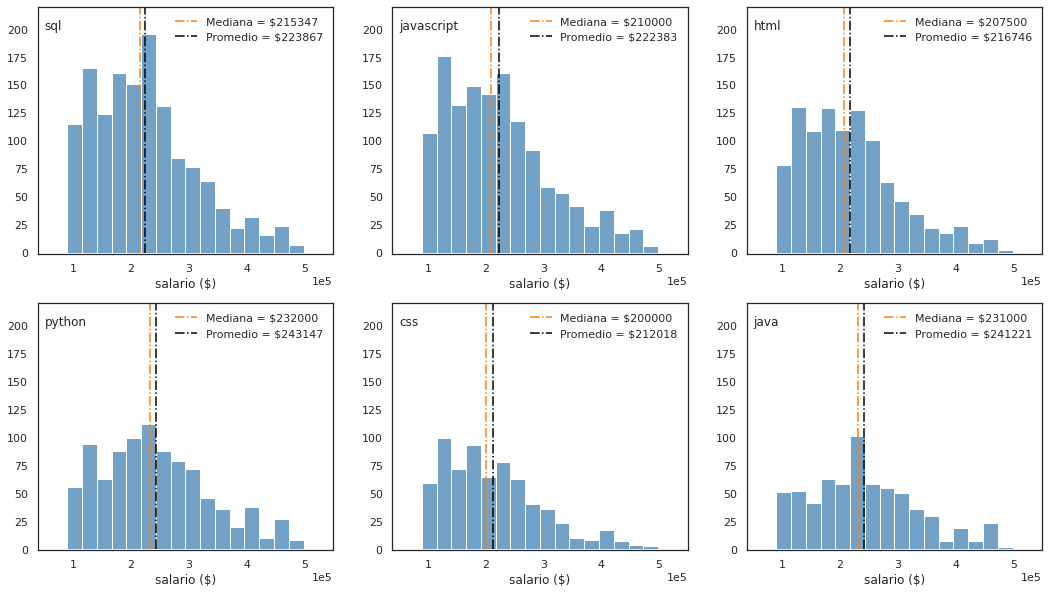

In [15]:
fig, axs = plt.subplots(2,3, figsize=(18,10))


m = 0
nbins=20
binrange = [38000, 0.55*10**6]

range_salary = -np.amin(df_intlang["salary_monthly_NETO"]) + np.amax(df_intlang["salary_monthly_NETO"])
ratio = []

for i in [0,1]:
    for j in [0,1,2]:
        data = df_intlang[df_intlang["programming_language"]==int_lang[m]]["salary_monthly_NETO"]

        sns.histplot(data, bins=nbins, binrange=binrange, ax=axs[i, j], color='steelblue')
        
        median = data.median()
        mean = data.mean()
        
        axs[i, j].vlines(median, 0, 220, color="tab:orange", label = f'Mediana = ${median:.0f}', ls='-.')
        axs[i, j].vlines(mean, 0, 220, color="black", label = f'Promedio = ${mean:.0f}', ls='-.')

        axs[i, j].annotate(f'{int_lang[m]}', xy = (0.5e5, 200), fontsize=12, ha='left')
        axs[i, j].legend(frameon=False, loc='best')

        axs[i, j].ticklabel_format(style='sci', axis='x', scilimits=(5,5))
        axs[i, j].set_ylim((-1,220))
        axs[i, j].set_xlim((38000, 0.55*10**6))
        axs[i, j].set_xlabel("salario ($)")
        axs[i, j].set_ylabel("")
        
        ratio.append( round((mean-median)/range_salary * 100, 2) )
        
        m += 1

print("razones por lenguaje:")
print()
for i in range (len(int_lang)):
    print(int_lang[i]+":", str(ratio[i])+"%")
        
plt.show()

### Respuesta con gráfico de cajas

---
# Ejercicio 2 - Densidades y varias variables

## Selección de filas y columnas

En este segundo ejercicio, debemos dar respuesta a **¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?** 

Dado un DataFrame, podemos considerar que cada columna es un conjunto de datos, los cuales se puede modelar con el concepto matemático de **variable aleatoria**. Luego, cada dato de esa columna es una **realización** u **observación** de dicha variable aleatoria. Habrá datos o intervalo de datos más frecuentes y otros más atípicos. Esto último se modela con el concepto de **distribución** o **densidad** de la variable aleatoria. Estas son las herramientas matemáticas que nos brinda la probabilidad y la estadística.

En particular, elegimos las variables categóricas work_province y profile_gender junto a las variables numéricas salary_monthly_NETO, profile_years_experience y profile_age. Partimos desde el DataFrame df85 utilizado en el ejercicio anterior, donde ya tenemos una serie de filtros aplicados.

In [16]:
relevant_columns = ["salary_monthly_NETO", 
                    "profile_years_experience", 
                    "profile_age", 
                    "work_province", 
                    "profile_gender"
                   ]

df2 = df85[relevant_columns] # Nuevo DataFrame

print(f'Cantidad inicial de filas: {total_ans}.')
df2 = df2.dropna(subset=relevant_columns)
print(f'Quedan {len(df2)} filas.')

Cantidad inicial de filas: 5358.
Quedan 3479 filas.


## Filtros

### Género

Dada que la encuesta no tiene respuestas prefijadas, la categoría contiene una gran variedad de respuestas equivalentes, sólo que escritas de distinta manera. En una primera instancia, se unificaron estas categorías para evitar ambigüedades y se graficó un histograma con las nuevas etiquetas.

Observamos que hay dos categorías dominantes, que son varon_cis y mujer_cis. Utilizando una escala logarítmica en el histograma, vemos que el resto está dos órdenes de magnitud por abajo. En base a esto, tomamos el criterio de agrupar las categorías minoritarias bajo la etiqueta "diversidades" para darle más significancia estadística para futuros análisis.

distintas respuestas a la sección 'genero'

originalmente:
['Varón Cis' 'Varón cis' 'Mujer Cis' 'Varón Trans' 'Queer' 'No binarie'
 'Mujer Trans' 'Mujer cis' 'Mujer' 'mujer' 'Gay' 'Fluido' 'Bigénero'
 'Femenino']
número de etiquetas:  14
------------------------------------------------------
unificando etiquetas equivalentes
['varon_cis' 'mujer_cis' 'varon_trans' 'queer' 'no_binarie' 'mujer_trans'
 'gay' 'fluido' 'bigenero']
número de etiquetas:  9
------------------------------------------------------
agrupando diversidades
['varon_cis' 'mujer_cis' 'diversidades']
número de etiquetas:  3


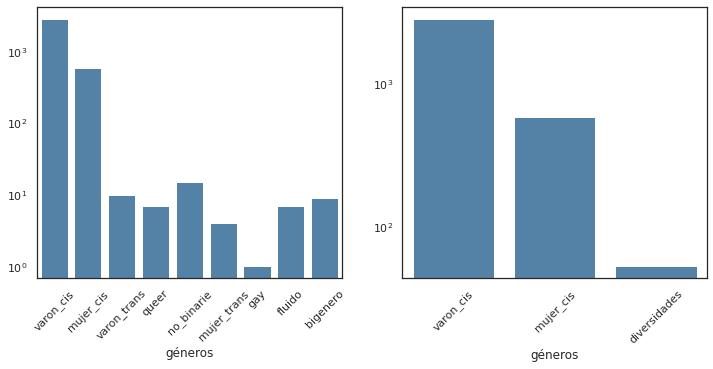

In [17]:
print("distintas respuestas a la sección 'genero'")
print()
print("originalmente:")
print(df2.profile_gender.unique())
print("número de etiquetas: ",len(df2.profile_gender.unique()))

print("------------------------------------------------------")

df2_gen = df2.copy()

df2_gen.loc[:,'profile_g'] = df2_gen.profile_gender.replace(
    {'Varón Cis': 'varon_cis',
     'Varón cis': 'varon_cis',
     'Mujer': 'mujer_cis',
     'Mujer Cis': 'mujer_cis',
     'Mujer cis': 'mujer_cis',
     'Femenino': 'mujer_cis',
     'mujer': 'mujer_cis',
     'Mujer':'mujer_cis',
     'Queer':'queer',
     'Varón Trans':'varon_trans',
     'No binarie':'no_binarie',
     'Mujer Trans':'mujer_trans',
     'Fluido':'fluido',
     'Bigénero':'bigenero',
     'Gay':'gay'
    })

print("unificando etiquetas equivalentes")
print(df2_gen.profile_g.unique())
print("número de etiquetas: ",len(df2_gen.profile_g.unique()))
print("------------------------------------------------------")

print("agrupando diversidades")

df2_gen2 = df2_gen.copy()
df2_gen2.loc[:,'profile_g'] = df2_gen2.profile_g.replace(
    {
     'queer':'diversidades',
     'varon_trans':'diversidades',
     'no_binarie':'diversidades',
     'mujer_trans':'diversidades',
     'fluido':'diversidades',
     'bigenero':'diversidades',
     'gay':'diversidades'
    })

print(df2_gen2.profile_g.unique())
print("número de etiquetas: ",len(df2_gen2.profile_g.unique()))

fig, ax = plt.subplots(1,2,figsize=(12,5))
sns.countplot(x=df2_gen.profile_g, color='steelblue', ax = ax[0])
sns.countplot(x=df2_gen2.profile_g, color='steelblue', ax = ax[1])

ax[0].set_xlabel("géneros")
ax[1].set_xlabel("géneros")
ax[0].set_ylabel("")
ax[1].set_ylabel("")
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[0].xaxis.set_tick_params(rotation=45)
ax[1].xaxis.set_tick_params(rotation=45)
plt.show()



### Provincias

Se analizaron las respuestas provistas a la sección 'work_province'. Observamos que el 88% de les programadorxs están concentrades en cuatro provincias principalmente: Ciudad Autónoma de Buenos Aires, Provincia de Buenos Aires, Córdoba y Santa Fe, las cuales fueron renombradas para mayor conveniencia. Los análisis posteriores estarán basados  sólo en estas cuatro provincias.



In [18]:
df_prov = df2_gen2.copy()

prov_count = df_prov.work_province.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'work_province', 'work_province': 'frequency'})

print(prov_count[:10])

print(f'Cantidad total de entradas: {len(df_prov)}.')
tops = np.sum(prov_count["frequency"][0:4])
int_prov = prov_count["work_province"][0:4].to_list()
print(f'Entradas en las 3 más populares: {tops}.')
print(f'Porcentaje de las 3 provincias mayoritarias: {tops * 100 / len(df_prov):.0f}%.')

#filtro
df_prov2 = df_prov[df_prov.work_province.isin(int_prov)]
#renombramos las etiquetas mayoritarias
df_prov2.loc[:,'work_prov'] = df_prov2.work_province.replace(
    {
        'Ciudad Autónoma de Buenos Aires':'caba',
        'Córdoba':'cordoba',
        'Provincia de Buenos Aires': 'bs_as',
        'Santa Fe':'santa_fe',
     })

                     work_province  frequency
0  Ciudad Autónoma de Buenos Aires       1836
1        Provincia de Buenos Aires        688
2                          Córdoba        302
3                         Santa Fe        225
4                          Mendoza         83
5                            Chaco         38
6                       Entre Ríos         38
7                        Río Negro         32
8                          Neuquén         31
9                            Salta         26
Cantidad total de entradas: 3479.
Entradas en las 3 más populares: 3051.
Porcentaje de las 3 provincias mayoritarias: 88%.


In [19]:

# fig, ax = plt.subplots(1,2,figsize=(12,5))
# sns.countplot(x=df_prov.work_province, color='steelblue', ax = ax[0])
# ax[0].set_xlabel("provincia")
# ax[0].set_ylabel("")
# ax[0].set_yscale("log")
# ax[0].xaxis.set_tick_params(rotation=90)
# ax[0].yaxis.get_ticklocs(minor=True)
# sns.countplot(x=df_prov2.work_province, color='steelblue', ax = ax[1])
# ax[1].set_xlabel("provincia")
# ax[1].set_ylabel("")
# ax[1].set_yscale("log")
# ax[1].xaxis.set_tick_params(rotation=90)
# ax[1].yaxis.get_ticklocs(minor=True)
# plt.show()


### Edades y años de experiencia

La edad laboral mínima en Argentina es de 18 años y la edad máxima jubilatoria es de 65 años. Filtramos los datos con estos criterios. 

Además, observamos en los datos que algunas personas o empezaron a trabajar antes de los 18 años, mintieron o se equivocaron en cargar los años de experiencia. En la tercera entrada por ejemplo, esa persona empezó a trabajar a los 13 años. Decidimos filtrar todos estos casos de la siguiente forma:

$$
    \text{edad}-18 \geq \text{años de experiencia}
$$



In [20]:
df_age = df_prov2.copy()

age_min = 18
age_max = 65

#filtro por edades laborales
df_age = df_age[df_age["profile_age"]>=age_min]
df_age = df_age[df_age["profile_age"]<=age_max]

#algunos datos sospechosos:
print(df_age[df_age["profile_age"]-age_min < df_age["profile_years_experience"]]\
      [["profile_age","profile_years_experience"]][0:10])

#filtro de datos sospechosos
df_age = df_age[df_age["profile_age"]-age_min >= df_age["profile_years_experience"]] # años de exp no superan edad




     profile_age  profile_years_experience
118           21                       4.0
269           46                      30.0
368           38                      25.0
373           38                      23.0
469           34                      25.0
518           25                       8.0
533           32                      20.0
862           38                      23.0
951           18                       1.0
956           19                       3.0


## a) Densidad conjunta


Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa




## b) Asociación


En base a lo realizado en el ejercicio 1 (ver secciones 'Análisis preliminar' y 'Filtrado/limpieza'), notamos que la gran mayoría de los datos tienen una correlación positiva en el sentido que cuando una variable crece, la otra también lo hace. Aquellos datos que rompen esta tendencia fueron descartados en base a los criterios ya discutidos previamente. En resumen, decidimos trabajar solamente con el salario neto. 

Para mejorar futuras encuestas, agregaríamos dichos criterios, o bien pedir sólamente el salario neto, ya que creemos que a la gente le importa más saber cuánto dinero le queda 'en el bolsillo'.

## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación





## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)